In [84]:
import gym
import gym_anytrading
from finta import TA
from gym_anytrading.envs import TradingEnv, Actions, Positions

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import jdc


In [85]:
df = pd.read_csv("data/DAX3015.csv")

df['timestamp'] = df['Date'].astype(str) + "." + df['Time'].astype(str)
del df['Time']
del df['Date']
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

df["Volume"] = df["Volume"].astype(float)

df = df.between_time('9:00', '18:00')

df['SMA12'] = TA.SMA(df, 12)
df['SMA50'] = TA.SMA(df, 50)
df['SMA200'] = TA.SMA(df, 200)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)



df.fillna(0, inplace=True)
df.head(10)

,Open,High,Low,Close,Volume,SMA12,SMA50,SMA200,RSI,OBV
timestamp,,,,,,,,,,
2020-10-06 14:00:00,12838.2,12851.0,12834.7,12840.5,951.0,0.0,0.0,0.0,0.000000,0.0
2020-10-06 14:15:00,12840.7,12878.3,12839.3,12874.1,995.0,0.0,0.0,0.0,100.000000,995.0
2020-10-06 14:30:00,12874.6,12906.9,12874.6,12894.7,1391.0,0.0,0.0,0.0,100.000000,2386.0
2020-10-06 14:45:00,12895.2,12904.7,12886.8,12889.9,998.0,0.0,0.0,0.0,90.926276,1388.0
2020-10-06 15:00:00,12890.4,12903.9,12873.4,12902.3,1080.0,0.0,0.0,0.0,92.755138,2468.0
2020-10-06 15:15:00,12902.8,12934.0,12901.1,12925.7,1219.0,0.0,0.0,0.0,94.860390,3687.0
2020-10-06 15:30:00,12925.2,12943.8,12924.1,12932.1,1439.0,0.0,0.0,0.0,95.265607,5126.0
2020-10-06 15:45:00,12933.1,12946.0,12930.0,12944.8,1068.0,0.0,0.0,0.0,95.948270,6194.0
2020-10-06 16:00:00,12945.3,12958.7,12935.9,12944.0,1239.0,0.0,0.0,0.0,95.018827,4955.0


In [86]:
class DaxEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, unit_side='left'):
        assert len(frame_bound) == 2
        assert unit_side.lower() in ['left', 'right']

        self.frame_bound = frame_bound
        self.unit_side = unit_side.lower()
        super().__init__(df, window_size)

        self.trade_fee = 0.0003  # unit

#env2 = MyCustomEnv(df=df, window_size=5, frame_bound=(210,400))

In [87]:
%%add_to DaxEnv
def add_signals(env):

    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Open', 'High', 'Low', 'Volume', 'SMA12', 'SMA50', 'SMA200', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features


In [88]:
%%add_to DaxEnv
def _process_data(self):
    prices = self.df.loc[:, 'Close'].to_numpy()

    prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
    prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

    diff = np.insert(np.diff(prices), 0, 0)
    signal_features = np.column_stack((prices, diff))

    return prices, signal_features

In [89]:
%%add_to DaxEnv
def _calculate_reward(self, action):
    step_reward = 0  # pip

    trade = False
    if ((action == Actions.Buy.value and self._position == Positions.Short) or
        (action == Actions.Sell.value and self._position == Positions.Long)):
        trade = True

    if trade:
        current_price = self.prices[self._current_tick]
        last_trade_price = self.prices[self._last_trade_tick]
        price_diff = current_price - last_trade_price

        if self._position == Positions.Short:
            step_reward += -price_diff
        elif self._position == Positions.Long:
            step_reward += price_diff

    return step_reward

In [90]:
%%add_to DaxEnv
def _update_profit(self, action):
    trade = False
    if ((action == Actions.Buy.value and self._position == Positions.Short) or
        (action == Actions.Sell.value and self._position == Positions.Long)):
        trade = True

    if trade or self._done:
        current_price = self.prices[self._current_tick]
        last_trade_price = self.prices[self._last_trade_tick]

        if self.unit_side == 'left':
            if self._position == Positions.Short:
                quantity = self._total_profit * (last_trade_price - self.trade_fee)
                self._total_profit = quantity / current_price

        elif self.unit_side == 'right':
            if self._position == Positions.Long:
                quantity = self._total_profit / last_trade_price
                self._total_profit = quantity * (current_price - self.trade_fee)

In [91]:
%%add_to DaxEnv
def max_possible_profit(self):
    current_tick = self._start_tick
    last_trade_tick = current_tick - 1
    profit = 1.

    while current_tick <= self._end_tick:
        position = None
        if self.prices[current_tick] < self.prices[current_tick - 1]:
            while (current_tick <= self._end_tick and
                    self.prices[current_tick] < self.prices[current_tick - 1]):
                current_tick += 1
            position = Positions.Short
        else:
            while (current_tick <= self._end_tick and
                    self.prices[current_tick] >= self.prices[current_tick - 1]):
                current_tick += 1
            position = Positions.Long

        current_price = self.prices[current_tick - 1]
        last_trade_price = self.prices[last_trade_tick]

        if self.unit_side == 'left':
            if position == Positions.Short:
                quantity = profit * (last_trade_price - self.trade_fee)
                profit = quantity / current_price

        elif self.unit_side == 'right':
            if position == Positions.Long:
                quantity = profit / last_trade_price
                profit = quantity * (current_price - self.trade_fee)

        last_trade_tick = current_tick - 1

    return profit

In [92]:
env2 = DaxEnv(df=df, window_size=5, frame_bound=(210,400))

In [93]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [94]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)

---------------------------------
| explained_variance | 0.183    |
| fps                | 1        |
| nupdates           | 1        |
| policy_entropy     | 0.692    |
| total_timesteps    | 5        |
| value_loss         | 170      |
---------------------------------
---------------------------------
| explained_variance | 3.8e-05  |
| fps                | 67       |
| nupdates           | 100      |
| policy_entropy     | 0.692    |
| total_timesteps    | 500      |
| value_loss         | 37.3     |
---------------------------------
---------------------------------
| explained_variance | 2e-05    |
| fps                | 91       |
| nupdates           | 200      |
| policy_entropy     | 0.692    |
| total_timesteps    | 1000     |
| value_loss         | 252      |
---------------------------------


KeyboardInterrupt: 

In [95]:
env = DaxEnv(df=df, window_size=5, frame_bound=(210,400))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 89.09999999999673, 'total_profit': 1.0221601963254925, 'position': 1}


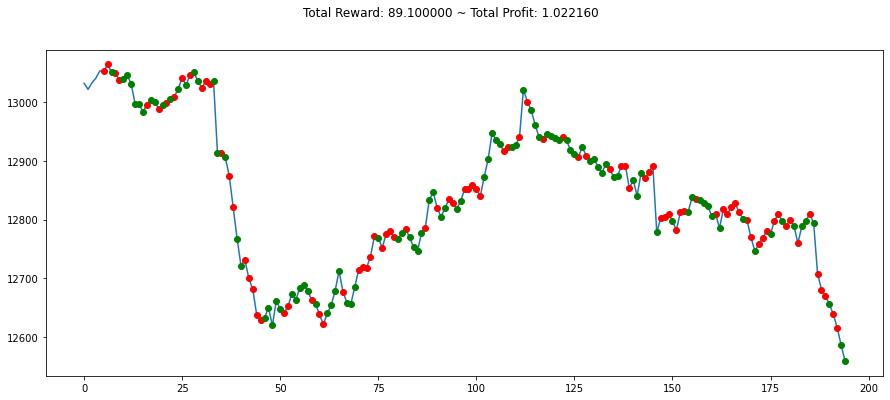

In [96]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [ ]:
0802201
